<a href="https://colab.research.google.com/github/yuhe6/Stat-430-Deep-Learning/blob/main/00b-pytorch-sine-estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

The goal of this notebook is to walkthrough the estimation of a relationship using a neural network written with PyTorch.

## Dependencies

To begin, there are a few dependencies that must be loaded. These dependencies are extensions to the Python language for deep learning.

In [13]:
# For neural networks
import torch.nn as nn
import torch
import torch.nn.functional as F

# For arrays
import numpy as np

# For working with images and creating visualizations
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

# For working with files and directories 
from pathlib import Path

# For TensorBoard visualization
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

## Problem

Let"s say we have data generated under the function $f(x) = \sin(x)$. If we turn over the data to a colleague without telling them the data generating procedure, would they be able to determine the relationship? Could linear regression be used to recover the graph? 

How can we re-construct $f(x)$ if we do not know the relationship? 

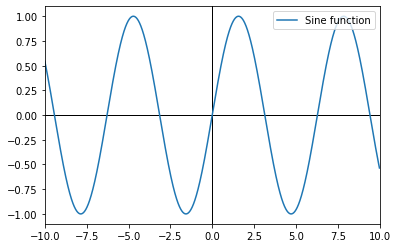

In [14]:
# Construct input and outputs
x_input = np.arange(-10, 10, 0.01)
true_output_sine = np.sin(x_input)

# Add lines through origin
plt.axhline(0, color="black", lw=1)
plt.axvline(0, color="black", lw=1)

# Graph Data
plt.plot(x_input, true_output_sine, label = "Sine function")

# Enforce a x-axis window
plt.xlim(-10, 10)

# Add a legend
plt.legend(loc = 1)

# Display graph
plt.show()

## Building a Neural Network

With the problem framing in-mind, we"ll construct our first ever neural network using Torch"s [`nn.Sequential()` container](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). 


In [15]:
from collections import OrderedDict
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

network = nn.Sequential(OrderedDict([
    ("input", nn.Linear(1,256)),
    ("elu1", torch.nn.ELU()),
    ("hidden_1", nn.Linear(256,256)),
    ("elu2", torch.nn.ELU()),
    ("hidden_2", nn.Linear(256,256)),
    ("elu3", torch.nn.ELU()),
    ("out", nn.Linear(256,1))
    ]))

# Display individual layers
for name, param in network.named_parameters():
  print(f"Layer: {name}, Shape: {param.shape}")

Layer: input.weight, Shape: torch.Size([256, 1])
Layer: input.bias, Shape: torch.Size([256])
Layer: hidden_1.weight, Shape: torch.Size([256, 256])
Layer: hidden_1.bias, Shape: torch.Size([256])
Layer: hidden_2.weight, Shape: torch.Size([256, 256])
Layer: hidden_2.bias, Shape: torch.Size([256])
Layer: out.weight, Shape: torch.Size([1, 256])
Layer: out.bias, Shape: torch.Size([1])


An alternative would be to construct a Python class based off of PyTorch's [`nn.module()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Approaching the problem this way separates the "initialization" phase from the "forward pass" phase.

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.input = nn.Linear(1,256)
        self.hidden_1 = nn.Linear(256,256)
        self.hidden_2 = nn.Linear(256,256)
        self.out = nn.Linear(256,1)
    
    def forward(self,x):
        x = self.input(x)
        x = F.elu(x)
        x = self.hidden_1(x)
        x = F.elu(x)
        x = self.hidden_2(x)
        x = F.elu(x)
        x = self.out(x)
        return x

# Detect if GPU is present
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

# Initialize Network
network_class = NeuralNetwork()

## Helper Functions

Let's create three helper functions to learn about the process the network is undergoing.  In particular, we'll create a function to make a progress plot similar to the one in the problem statement, training loss history, and a function to generate training data. 

In [17]:
def plot_progress(x_input, y_true, y_network, id, output_path = "training_plots"):
  # Create a directory if not present
  Path(output_path).mkdir(parents=True, exist_ok=True)

  # Add lines through origin
  plt.axhline(0, color="black", lw=1)
  plt.axvline(0, color="black", lw=1)
  
  # Graph Data
  plt.plot(x_input, y_true, label = "Sine Function")
  plt.plot(x_input, y_network, label = "Estimated Function")

  plt.title(f"Epoch: {id}")

  # Enforce a x-axis window
  plt.xlim(-10, 10)

  # Enforce a y-axis window
  plt.ylim(-1.1, 1.1)
  
  # Add a legend
  plt.legend(loc = 1)
  
  # Display graph
  plt.savefig(f"{output_path}/{id:06d}.png")

  # Clear the plot to avoid costly rebuilds.
  plt.clf()

  # Avoid returning anything
  return None

In [18]:
def training_loss(loss_history):
  plt.plot(range(len(loss_history)), loss_history, label = "Loss")
  plt.show()

In [19]:
def training_data(batch_size, device):
  # Randomly
  nums = np.random.uniform(-10, 10, batch_size)
  x = torch.Tensor(nums, device = device)
  y = torch.Tensor(np.sin(nums), device = device)
  y = y.view(batch_size, -1)
  return x, y

## Training a Network



In [ ]:
# Detect if GPU is present
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

# Write a wrapper function for network training steps
def train_sine_network(network, epochs = 2000, device = torch.device("cpu"), gif = False):

  # Use the ADAM optimizer
  optimizer = torch.optim.Adam(network.parameters(), lr = 3e-4)

  # Measure loss using the Mean Squared Error function.
  loss_criterion = torch.nn.MSELoss()

  # Store a history of loss
  loss_history = list()

  # Set number of observations to consider
  batch_size = 128

  # Setup inputs for graphing
  x_input = np.arange(-10, 10, 0.01)
  # Compute true values
  true_value_sine = np.sin(x_input)

  # Train the model
  for epoch in range(epochs):

    # Display progress
    if epoch % 250 == 0 and epoch != 0:
      print(f"Epoch: {epoch}, Loss: {loss_history[-1]:.5f}")
    
    # Export network state
    if gif:
      # Compute a prediction
      with torch.no_grad():
        network_prediction_sine = network(torch.Tensor(x_input).view(-1, 1)).squeeze().numpy()
      # Create a progress plot of reconstructing the function
      plot_progress(x_input, true_value_sine, network_prediction_sine, id = epoch)

    # Train network
    x, y = training_data(batch_size, device)
    optimizer.zero_grad()
    net_output = network(x.view(batch_size,-1))
    loss_value = loss_criterion(y, net_output)

    # Write 
    writer.add_scalar("Loss/train", loss_value, epoch)

    # Handle backpropagation and training
    loss_value.backward()
    optimizer.step()

    # Save loss value for history
    loss_history.append(loss_value.item())
  
  # Save the trained network weights
  torch.save(network.state_dict(), "sine_network_weights.pt")

  return network, loss_history

# Train the network
trained_network, loss_history = train_sine_network(network, epochs = 1250, device = device, gif = True)

# Ensure we"ve written everything
writer.flush()

Epoch: 250, Loss: 0.12732


## Visualize Training

Next, let's aim to visualize the output with our training loss history function.

In [ ]:
training_loss(loss_history)

We can also use a more common industry approach with TensorBoard. To that end, we rely on using automagic to load the TensorBoard application into the notebook.


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

From here, we need to launch TensorBoard pointed at the `runs` log directory to obtain a similar training plot visualization.

**Note:** The `Writer` we setup in the dependency load section at the top of the notebook will output to `./runs` directory by default.


In [ ]:
%tensorboard --logdir runs

## Creating a gif

We can merge together the different training progress graphs to see how well the network performed.

In [ ]:
def create_gif(training_plot_path):
  with imageio.get_writer("sine-function-approximation.gif", mode = "I", duration = 1/60) as writer:
    for filename in sorted(Path(training_plot_path).glob("*.png"), key = str)[:1000]:
      image = imageio.imread(filename)
      writer.append_data(image)

create_gif("training_plots")

The resulting gif is a little large (~30 mb). So, we'll need to reduce the file size with using a trick. Note, we're now in the territory of an explicit dependency on Colab due to the need for system-specific software.

In [ ]:
# Install a python package
!pip install pygifsicle

# Install a linux package
!apt install gifsicle

Once the software is installed, we'll aim to "optimize" the GIF.

In [ ]:
from pygifsicle import optimize
# Try to reduce the file size
optimize("sine-function-approximation.gif")

Now, let's visualize it! 

In [ ]:
from IPython.display import Image
Image(open("sine-function-approximation.gif","rb").read())